For this project, we adopted two different datasets, mentioned below.

ASL alphabet dataset : https://www.kaggle.com/datasets/grassknoted/asl-alphabet

Chatbot dataset : https://www.kaggle.com/datasets/kreeshrajani/3k-conversations-dataset-for-chatbot

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import DataCollatorForLanguageModeling, TrainingArguments, Trainer
from datasets import load_dataset, load_metric

c:\Users\Paul\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Chatbot Dataset - EDA and preprocessing

In [2]:
chatbot_df = pd.read_csv('Conversation.csv')
chatbot_df = chatbot_df.drop(columns = ['Unnamed: 0'])

In [3]:
chatbot_df.head()

question  \
0               hi, how are you doing?   
1        i'm fine. how about yourself?   
2  i'm pretty good. thanks for asking.   
3    no problem. so how have you been?   
4     i've been great. what about you?   

                                     answer  
0             i'm fine. how about yourself?  
1       i'm pretty good. thanks for asking.  
2         no problem. so how have you been?  
3          i've been great. what about you?  
4  i've been good. i'm in school right now.

In [4]:
chatbot_df.shape

(3725, 2)

#### EDA

EDA was performed by following a similar procedure to the one described by Singh (n.d.).

References:

Singh, H. (n.d.). Complete Guide to EDA on Text Data. Kaggle. https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data

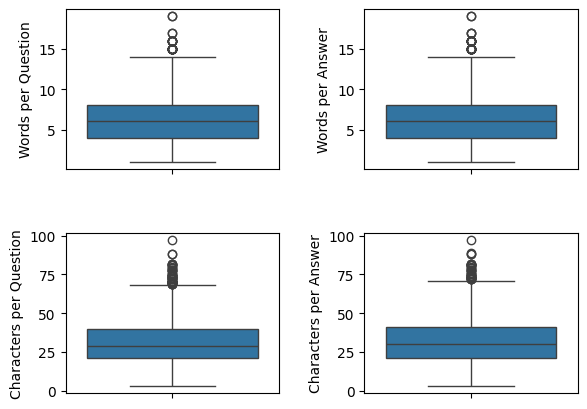

In [5]:
# Function to count the number of words in a sentence
def count_words(text):
    words = text.split() # extract the words from text
    num_words = len(words) # count the number of words
    return num_words

# Function to count the number of characters in a sentence
def count_characters(text):
    num_char = len(text) # count the number of chatacters
    return num_char

num_words_question = chatbot_df['question'].apply(count_words)
num_words_answer = chatbot_df['answer'].apply(count_words)
num_char_question = chatbot_df['question'].apply(count_characters)
num_char_answer = chatbot_df['answer'].apply(count_characters)

plt.subplot(2, 2, 1)
sns.boxplot(y = num_words_question)
plt.ylabel('Words per Question')
plt.subplot(2, 2, 2)
sns.boxplot(y = num_words_answer)
plt.ylabel('Words per Answer')
plt.subplot(2, 2, 3)
sns.boxplot(y = num_char_question)
plt.ylabel('Characters per Question')
plt.subplot(2, 2, 4)
sns.boxplot(y = num_char_answer)
plt.ylabel('Characters per Answer')
plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.4, hspace = 0.4)
plt.savefig('Figure3.png')
plt.show()

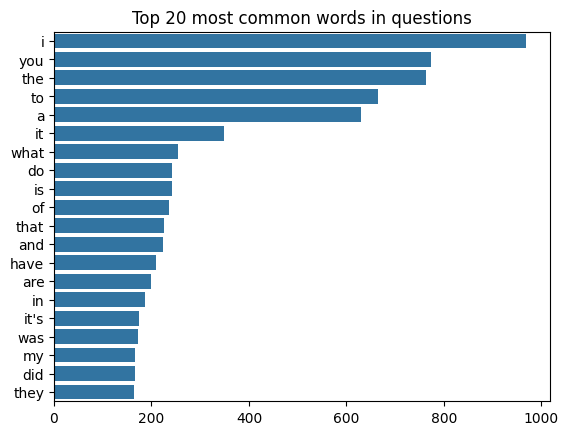

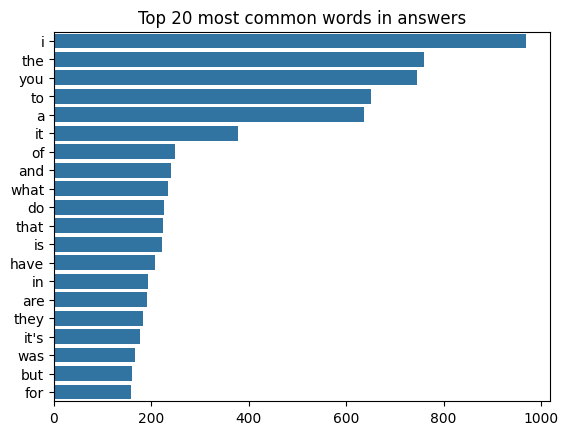

In [6]:
# Identify the most frequent words in the question/answer columns

# Function to get the list of words in a sentence
def list_words(text):
    words = text.split() # extract the words from text
    return words

# Function to get the top 20 most common words and their counts
def words_freq(mostcommon):
    words = []
    counts = []
    for word, count in mostcommon:
        words.append(word)
        counts.append(count)
    return words, counts

words_question = chatbot_df['question'].apply(list_words)
words_answer = chatbot_df['answer'].apply(list_words)
corpus_question = []
for jj in range(len(words_question)):
    corpus_question += words_question[jj] # all the words in all the questions
corpus_answer = []
for jj in range(len(words_answer)):
    corpus_answer += words_answer[jj] # all the words in all the answers
mostcommon_words_question = Counter(corpus_question).most_common(20) # 20 most common words in all the questions
mostcommon_words_answer = Counter(corpus_answer).most_common(20) # 20 most common words in all the answers
words_question, counts_question = words_freq(mostcommon_words_question) # top 20 most common words and their counts in questions
words_answer, counts_answer = words_freq(mostcommon_words_answer) # top 20 most common words and their counts in answers

sns.barplot(x = counts_question, y = words_question)
plt.title('Top 20 most common words in questions')
plt.show()

sns.barplot(x = counts_answer, y = words_answer)
plt.title('Top 20 most common words in answers')
plt.show()

#### Preprocessing

In order to replace contractions, we adopted the same procedure described in Replace apostrophe/short words in python (n.d.). 

References: 

Replace apostrophe/short words in python. (n.d.). Stack Overflow. Retrieved July 24, 2024, from https://owl.purdue.edu/owl/research_and_citation/apa_style/apa_formatting_and_style_guide/reference_list_electronic_sources.html

In [7]:
# List of common contractions 
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

# Function to replace contractions, remove punctuation and apply lowercase
def clear_text(text):
    for word in text.split(): # remove contractions and apply lowercase
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    return text

chatbot_df['question'] = chatbot_df['question'].apply(clear_text)
chatbot_df['answer'] = chatbot_df['answer'].apply(clear_text)
chatbot_df.head()

question  \
0                hi how are you doing   
1        I am fine how about yourself   
2  I am pretty good thanks for asking   
3     no problem so how have you been   
4    I have been great what about you   

                                      answer  
0               I am fine how about yourself  
1         I am pretty good thanks for asking  
2            no problem so how have you been  
3           I have been great what about you  
4  I have been good I am in school right now

In [8]:
# Tokenization
chatbot_df['token_question'] = chatbot_df['question'].apply(nltk.word_tokenize)
chatbot_df['token_answer'] = chatbot_df['answer'].apply(nltk.word_tokenize)
chatbot_df.head()

question  \
0                hi how are you doing   
1        I am fine how about yourself   
2  I am pretty good thanks for asking   
3     no problem so how have you been   
4    I have been great what about you   

                                      answer  \
0               I am fine how about yourself   
1         I am pretty good thanks for asking   
2            no problem so how have you been   
3           I have been great what about you   
4  I have been good I am in school right now   

                               token_question  \
0                  [hi, how, are, you, doing]   
1         [I, am, fine, how, about, yourself]   
2  [I, am, pretty, good, thanks, for, asking]   
3     [no, problem, so, how, have, you, been]   
4    [I, have, been, great, what, about, you]   

                                        token_answer  
0                [I, am, fine, how, about, yourself]  
1         [I, am, pretty, good, thanks, for, asking]  
2            [no, problem, so, how, have, you, been]  
3           [I, have, been, great, what, about, you]  
4  [I, have, been, good, I, am, in, school, right...

In [9]:
# Lemmatization

# Function to obtain the right positional tagging prior to lemmatization
# Same function presented in Python – Lemmatization Approaches with Examples (n.d.)
def right_pos_tagging(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Obtain the right positional tagging prior to lemmatization
# Positional tags were modified as suggested by Python – Lemmatization Approaches with Examples (n.d.)

tokens = chatbot_df['token_question']
new_tag_tokens = []
for jj in range(len(tokens)):
    tokens_jj = tokens[jj] # tokens at the jjth row
    tag_tokens_jj = nltk.pos_tag(tokens_jj) # POS tags for the generic tokens_jj
    new_tag_tokens.append(list(map(lambda x: (x[0], right_pos_tagging(x[1])), tag_tokens_jj))) # modified POS tags for the generic tokens_jj (as Python – Lemmatization Approaches with Examples, n.d.)
tagged_token_question = new_tag_tokens

tokens = chatbot_df['token_answer']
new_tag_tokens = []
for jj in range(len(tokens)):
    tokens_jj = tokens[jj] # tokens at the jjth row
    tag_tokens_jj = nltk.pos_tag(tokens_jj) # POS tags for the generic tokens_jj
    new_tag_tokens.append(list(map(lambda x: (x[0], right_pos_tagging(x[1])), tag_tokens_jj))) # modified POS tags for the generic tokens_jj (as Python – Lemmatization Approaches with Examples, n.d.)
tagged_token_answer = new_tag_tokens

# Implement lemmatization on the tokens
# A procedure similar to the one described in Python – Lemmatization Approaches with Examples (n.d.) and by Kumar (2021) was applied

wnl = WordNetLemmatizer()
Lemmatization = []
for jj in range(len(tagged_token_question)):
    lemmatized_question = []
# Same lines of codes used in Python – Lemmatization Approaches with Examples (n.d.)
    for word, tag in tagged_token_question[jj]:
        if tag is None:
            lemmatized_question.append(word)
        else:
            lemmatized_question.append(wnl.lemmatize(word, tag))
    Lemmatization.append(lemmatized_question)
chatbot_df['lem_question'] = Lemmatization

Lemmatization = []
for jj in range(len(tagged_token_answer)):
    lemmatized_answer = []
# Same lines of codes used in Python – Lemmatization Approaches with Examples (n.d.)
    for word, tag in tagged_token_answer[jj]:
        if tag is None:
            lemmatized_answer.append(word)
        else:
            lemmatized_answer.append(wnl.lemmatize(word, tag))
    Lemmatization.append(lemmatized_answer)
chatbot_df['lem_answer'] = Lemmatization

chatbot_df.head()

# References
# Kumar, R. (2021, August 6). Natural Language Processing | Text Preprocessing | Spacy vs NLTK. Medium. https://medium.com/nerd-for-tech/natural-language-processing-text-preprocessing-spacy-vs-nltk-b70b734f5560
# Python – Lemmatization Approaches with Examples. (n.d.). Geeks for Geeks.  https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/

question  \
0                hi how are you doing   
1        I am fine how about yourself   
2  I am pretty good thanks for asking   
3     no problem so how have you been   
4    I have been great what about you   

                                      answer  \
0               I am fine how about yourself   
1         I am pretty good thanks for asking   
2            no problem so how have you been   
3           I have been great what about you   
4  I have been good I am in school right now   

                               token_question  \
0                  [hi, how, are, you, doing]   
1         [I, am, fine, how, about, yourself]   
2  [I, am, pretty, good, thanks, for, asking]   
3     [no, problem, so, how, have, you, been]   
4    [I, have, been, great, what, about, you]   

                                        token_answer  \
0                [I, am, fine, how, about, yourself]   
1         [I, am, pretty, good, thanks, for, asking]   
2            [no, problem, so, how, have, you, been]   
3           [I, have, been, great, what, about, you]   
4  [I, have, been, good, I, am, in, school, right...   

                              lem_question  \
0                   [hi, how, be, you, do]   
1      [I, be, fine, how, about, yourself]   
2  [I, be, pretty, good, thanks, for, ask]   
3    [no, problem, so, how, have, you, be]   
4   [I, have, be, great, what, about, you]   

                                          lem_answer  
0                [I, be, fine, how, about, yourself]  
1            [I, be, pretty, good, thanks, for, ask]  
2              [no, problem, so, how, have, you, be]  
3             [I, have, be, great, what, about, you]  
4  [I, have, be, good, I, be, in, school, right, ...

## GPT-2 Fine Tuning

This section was created based on a combination of the following references.

References: 
https://github.com/arham-kk/gpt2-finetune/blob/main/model.ipynb
https://www.kaggle.com/code/arjunsaxena09/gpt-2-fine-tuning
https://www.kaggle.com/code/kreeshrajani/fine-tune-t5-for-conversational-model

#### Import tokenizer and model

In [10]:
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name, force_download = True)
model = GPT2LMHeadModel.from_pretrained(model_name, force_download = True)

#### Data preprocessing

In [11]:
# Initialize the data
data = chatbot_df.drop(columns = ['token_question', 'token_answer', 'lem_question', 'lem_answer'])
data

question  \
0                                  hi how are you doing   
1                          I am fine how about yourself   
2                    I am pretty good thanks for asking   
3                       no problem so how have you been   
4                      I have been great what about you   
...                                                 ...   
3720  that has  that is a good question maybe it has...   
3721                                are you righthanded   
3722                                    yes all my life   
3723  you are wearing out your right hand stop using...   
3724         but i do all my writing with my right hand   

                                                 answer  
0                          I am fine how about yourself  
1                    I am pretty good thanks for asking  
2                       no problem so how have you been  
3                      I have been great what about you  
4             I have been good I am in school right now  
...                                                 ...  
3720                                are you righthanded  
3721                                    yes all my life  
3722  you are wearing out your right hand stop using...  
3723         but i do all my writing with my right hand  
3724  start typing instead that way your left hand w...  

[3725 rows x 2 columns]

In [12]:
# Define train and test data
data_train, data_val = train_test_split(data,test_size = 0.2, random_state = 100)

# Convert the dataframes to a dataset objects
train_data = Dataset.from_pandas(data_train)
val_data = Dataset.from_pandas(data_val)

In [13]:
# Set the pad token
tokenizer.pad_token = tokenizer.eos_token

# Functions to tokenize questions and answers
def tokenize_que_ans(df):
    inputs = tokenizer(df['question'], add_special_tokens = True, max_length = 512, padding = 'max_length', truncation = True, return_attention_mask = True, return_tensors = 'pt')
    labels = tokenizer(df['answer'], add_special_tokens = True, max_length = 512, padding = 'max_length', truncation = True, return_attention_mask = True, return_tensors = 'pt')
    return {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask'], 'labels': labels['input_ids']}

# Apply tokenize_que_ans to data_train and data_val
train_data = train_data.map(tokenize_que_ans, batched = True)
val_data = val_data.map(tokenize_que_ans, batched = True)

Map: 100%|██████████| 745/745 [00:00<00:00, 4272.60 examples/s]


#### Training

In [14]:
# Define data collator
data_collator = DataCollatorForLanguageModeling(tokenizer = tokenizer, mlm = False)

# Define training arguments
training_args = TrainingArguments(
    output_dir = './model',
    overwrite_output_dir = True, 
    num_train_epochs = 1, 
    per_device_train_batch_size = 2,
    evaluation_strategy = 'steps',
    eval_steps = 100,
    save_steps = 500,
    logging_steps = 100, 
    logging_dir = './logs',
)

# Initialize the Trainer
trainer = Trainer(
    model = model, 
    args = training_args, 
    data_collator = data_collator, 
    train_dataset = train_data, 
    eval_dataset = val_data,
)

In [15]:
# Fine-tune the model
# trainer.train()

The following columns in the training set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: __index_level_0__, answer, question. If __index_level_0__, answer, question are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
c:\Users\Paul\anaconda3\envs\torch\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2980
  Num Epochs = 1
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 1490
  7%|▋         | 100/1490 [00:06<01:24, 16.42it/s]The following columns in the evaluation set don't have a corresponding argument in `GPT2L

{'loss': 4.4558, 'learning_rate': 4.664429530201342e-05, 'epoch': 0.07}


                                                  
  7%|▋         | 103/1490 [00:12<16:34,  1.40it/s]

{'eval_loss': 3.8935835361480713, 'eval_runtime': 6.2469, 'eval_samples_per_second': 119.259, 'eval_steps_per_second': 15.047, 'epoch': 0.07}


 13%|█▎        | 200/1490 [00:18<01:24, 15.35it/s]The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: __index_level_0__, answer, question. If __index_level_0__, answer, question are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 745
  Batch size = 8


{'loss': 4.3601, 'learning_rate': 4.328859060402685e-05, 'epoch': 0.13}


                                                  
 14%|█▎        | 203/1490 [00:25<16:34,  1.29it/s]

{'eval_loss': 3.7973594665527344, 'eval_runtime': 6.7135, 'eval_samples_per_second': 110.97, 'eval_steps_per_second': 14.002, 'epoch': 0.13}


 20%|██        | 300/1490 [00:31<01:10, 16.89it/s]The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: __index_level_0__, answer, question. If __index_level_0__, answer, question are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 745
  Batch size = 8


{'loss': 4.0503, 'learning_rate': 3.993288590604027e-05, 'epoch': 0.2}


                                                  
 20%|██        | 303/1490 [00:38<13:59,  1.41it/s]

{'eval_loss': 3.6913657188415527, 'eval_runtime': 6.1701, 'eval_samples_per_second': 120.744, 'eval_steps_per_second': 15.235, 'epoch': 0.2}


 27%|██▋       | 400/1490 [00:44<01:16, 14.16it/s]The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: __index_level_0__, answer, question. If __index_level_0__, answer, question are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 745
  Batch size = 8


{'loss': 3.9501, 'learning_rate': 3.6577181208053695e-05, 'epoch': 0.27}


                                                  
 27%|██▋       | 403/1490 [00:50<13:14,  1.37it/s]

{'eval_loss': 3.6638894081115723, 'eval_runtime': 6.3379, 'eval_samples_per_second': 117.546, 'eval_steps_per_second': 14.831, 'epoch': 0.27}


 34%|███▎      | 500/1490 [00:56<01:00, 16.49it/s]The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: __index_level_0__, answer, question. If __index_level_0__, answer, question are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 745
  Batch size = 8


{'loss': 3.8449, 'learning_rate': 3.3221476510067115e-05, 'epoch': 0.34}


                                                  
 34%|███▎      | 500/1490 [01:02<01:00, 16.49it/s]Saving model checkpoint to ./model\checkpoint-500
Configuration saved in ./model\checkpoint-500\config.json


{'eval_loss': 3.580962657928467, 'eval_runtime': 6.3622, 'eval_samples_per_second': 117.099, 'eval_steps_per_second': 14.775, 'epoch': 0.34}


Model weights saved in ./model\checkpoint-500\pytorch_model.bin
 40%|████      | 600/1490 [01:09<00:54, 16.43it/s]The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: __index_level_0__, answer, question. If __index_level_0__, answer, question are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 745
  Batch size = 8


{'loss': 4.0508, 'learning_rate': 2.986577181208054e-05, 'epoch': 0.4}


                                                  
 40%|████      | 601/1490 [01:16<15:13,  1.03s/it]

{'eval_loss': 3.5526199340820312, 'eval_runtime': 6.4312, 'eval_samples_per_second': 115.842, 'eval_steps_per_second': 14.616, 'epoch': 0.4}


 47%|████▋     | 700/1490 [01:23<00:50, 15.62it/s]The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: __index_level_0__, answer, question. If __index_level_0__, answer, question are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 745
  Batch size = 8


{'loss': 3.7968, 'learning_rate': 2.651006711409396e-05, 'epoch': 0.47}


                                                  
 47%|████▋     | 701/1490 [01:29<13:14,  1.01s/it]

{'eval_loss': 3.5021817684173584, 'eval_runtime': 6.2776, 'eval_samples_per_second': 118.677, 'eval_steps_per_second': 14.974, 'epoch': 0.47}


 54%|█████▎    | 800/1490 [01:35<00:41, 16.43it/s]The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: __index_level_0__, answer, question. If __index_level_0__, answer, question are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 745
  Batch size = 8


{'loss': 3.7922, 'learning_rate': 2.3154362416107384e-05, 'epoch': 0.54}


                                                  
 54%|█████▍    | 803/1490 [01:42<08:18,  1.38it/s]

{'eval_loss': 3.4673290252685547, 'eval_runtime': 6.3201, 'eval_samples_per_second': 117.877, 'eval_steps_per_second': 14.873, 'epoch': 0.54}


 60%|██████    | 900/1490 [01:48<00:35, 16.67it/s]The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: __index_level_0__, answer, question. If __index_level_0__, answer, question are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 745
  Batch size = 8


{'loss': 3.8278, 'learning_rate': 1.9798657718120804e-05, 'epoch': 0.6}


                                                  
 60%|██████    | 901/1490 [01:54<09:55,  1.01s/it]

{'eval_loss': 3.4377365112304688, 'eval_runtime': 6.3081, 'eval_samples_per_second': 118.103, 'eval_steps_per_second': 14.902, 'epoch': 0.6}


 67%|██████▋   | 1000/1490 [02:00<00:33, 14.41it/s]The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: __index_level_0__, answer, question. If __index_level_0__, answer, question are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 745
  Batch size = 8


{'loss': 3.7322, 'learning_rate': 1.644295302013423e-05, 'epoch': 0.67}


                                                   
 67%|██████▋   | 1000/1490 [02:07<00:33, 14.41it/s]Saving model checkpoint to ./model\checkpoint-1000
Configuration saved in ./model\checkpoint-1000\config.json


{'eval_loss': 3.4265549182891846, 'eval_runtime': 6.2164, 'eval_samples_per_second': 119.843, 'eval_steps_per_second': 15.121, 'epoch': 0.67}


Model weights saved in ./model\checkpoint-1000\pytorch_model.bin
 74%|███████▍  | 1100/1490 [02:14<00:26, 14.75it/s]The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: __index_level_0__, answer, question. If __index_level_0__, answer, question are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 745
  Batch size = 8


{'loss': 3.6228, 'learning_rate': 1.3087248322147652e-05, 'epoch': 0.74}


                                                   
 74%|███████▍  | 1103/1490 [02:21<04:43,  1.36it/s]

{'eval_loss': 3.4139373302459717, 'eval_runtime': 6.3452, 'eval_samples_per_second': 117.411, 'eval_steps_per_second': 14.814, 'epoch': 0.74}


 81%|████████  | 1200/1490 [02:27<00:21, 13.47it/s]The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: __index_level_0__, answer, question. If __index_level_0__, answer, question are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 745
  Batch size = 8


{'loss': 3.4547, 'learning_rate': 9.731543624161075e-06, 'epoch': 0.81}


                                                   
 81%|████████  | 1201/1490 [02:33<04:55,  1.02s/it]

{'eval_loss': 3.3931338787078857, 'eval_runtime': 6.3187, 'eval_samples_per_second': 117.904, 'eval_steps_per_second': 14.877, 'epoch': 0.81}


 87%|████████▋ | 1300/1490 [02:40<00:12, 15.74it/s]The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: __index_level_0__, answer, question. If __index_level_0__, answer, question are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 745
  Batch size = 8


{'loss': 3.5063, 'learning_rate': 6.375838926174497e-06, 'epoch': 0.87}


                                                   
 87%|████████▋ | 1301/1490 [02:46<03:12,  1.02s/it]

{'eval_loss': 3.3819546699523926, 'eval_runtime': 6.3328, 'eval_samples_per_second': 117.642, 'eval_steps_per_second': 14.843, 'epoch': 0.87}


 94%|█████████▍| 1400/1490 [02:52<00:05, 15.77it/s]The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: __index_level_0__, answer, question. If __index_level_0__, answer, question are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 745
  Batch size = 8


{'loss': 3.5688, 'learning_rate': 3.02013422818792e-06, 'epoch': 0.94}


                                                   
 94%|█████████▍| 1403/1490 [02:59<01:03,  1.38it/s]

{'eval_loss': 3.3730597496032715, 'eval_runtime': 6.3277, 'eval_samples_per_second': 117.736, 'eval_steps_per_second': 14.855, 'epoch': 0.94}


100%|█████████▉| 1489/1490 [03:04<00:00, 15.68it/s]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 1490/1490 [03:04<00:00,  8.05it/s]

{'train_runtime': 184.9821, 'train_samples_per_second': 16.11, 'train_steps_per_second': 8.055, 'train_loss': 3.8354569607933096, 'epoch': 1.0}


TrainOutput(global_step=1490, training_loss=3.8354569607933096, metrics={'train_runtime': 184.9821, 'train_samples_per_second': 16.11, 'train_steps_per_second': 8.055, 'train_loss': 3.8354569607933096, 'epoch': 1.0})

#### Save the fine-tuned model

In [16]:
# Save the fine-tuned model
trainer.save_model('gpt2-fine-tuned')

Saving model checkpoint to gpt2-fine-tuned
Configuration saved in gpt2-fine-tuned\config.json
Model weights saved in gpt2-fine-tuned\pytorch_model.bin


#### Inference

In [30]:
# # Define the model to use for predictions
# model = GPT2LMHeadModel.from_pretrained('gpt2-fine-tuned')

# # Function to generate the answer for a given question
# def generate_answer(question):
    
#     # Tokenize the question
#     inputs_encoding = tokenizer(question, add_special_tokens = True, max_length = 512, padding = 'max_length', truncation = 'only_first', return_attention_mask = True, return_tensors = 'pt')
    
#     # Generate a sequence based on the question
#     generate_ids = model.generate(input_ids = inputs_encoding['input_ids'], attention_mask = inputs_encoding['attention_mask'], max_length = 512, num_beams = 4, num_return_sequences = 1, no_repeat_ngrams_size = 2, early_stopping = True)
    
#     # Decode the generated sequence of tokens into text
#     generate_text = tokenizer.decode(generate_ids[0], skip_special_tokens = True)
    
#     return generate_text

model = GPT2LMHeadModel.from_pretrained('gpt2-fine-tuned')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-fine-tuned')

# Function to generate the answer for a given question
def generate_answer(question):
    
    # Tokenize the question
    inputs_encoding = tokenizer(question, add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
    
    # Generate a sequence based on the question
    generate_ids = model.generate(input_ids=inputs_encoding['input_ids'], attention_mask=inputs_encoding['attention_mask'], max_length=512, num_beams=4, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True)
    
    # Decode the generated sequence of tokens into text
    generate_text = tokenizer.decode(generate_ids[0], skip_special_tokens=True)
    
    return generate_text

# Example usage
question = "What is the capital of France?"
answer = generate_answer(question)
print(answer)

loading configuration file gpt2-fine-tuned\config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dtype": "float32",
  "transformers_version": "4.21.3",
  "use_cache": true,
  "vocab_size": 50257
}

loading weigh

ValueError: Asking to pad but the tokenizer does not have a padding token. Please select a token to use as `pad_token` `(tokenizer.pad_token = tokenizer.eos_token e.g.)` or add a new pad token via `tokenizer.add_special_tokens({'pad_token': '[PAD]'})`.

#### Model evaluation

In [28]:
question = 'Hello, how are you?'
print('You: ', question)
print('BOT: ', generate_answer(question))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but `max_length` is set to 1024. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


You:  Hello, how are you?


RuntimeError: The expanded size of the tensor (1024) must match the existing size (1025) at non-singleton dimension 0.  Target sizes: [1024].  Tensor sizes: [1025]

In [ ]:
question = 'Do you know where Paris is?'
print('You: ', question)
print('BOT: ', generate_answer(question))

In [ ]:
question = 'What is artificial intelligence?'
print('You: ', question)
print('BOT: ', generate_answer(question))